![car](car.jpeg)

# <span style="color:#d82a45">**Code Competition 12/2021:**</span> <span style="color:#4c575f">BIG DATA Predictions</span>
## <span style="color:#4c575f">Final Report - Korbinian Koch</span>

![sponge](https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/120/google/313/sponge_1f9fd.png)

## <span style="color:#d82a45">**Chapter 1:**</span> <span style="color:#4c575f">Cleaning and Understanding the Data</span>
The supplied .csv file contained a multitude of errors, which are analyzed and fixed in the following sections.

First, let's take a look at what we have.

In [1]:
# Set style of jupyter notebook
!jt -t grade3 -fs 10 -altp -nfs 115 -nf georgiaserif -tfs 115 -tf opensans -m 200 -cellw 70% -T
from jupyterthemes import jtplot
jtplot.style()

# Create toggle function
from IPython.display import HTML
import random

def toggle_cell(toggle_text='Show/hide cell', for_next=False):
    """
    This function allows you to hide/show a cell with a single click.
    """
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = toggle_text  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a style="color:#d82a45", href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

toggle_cell()

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('races.csv', sep=';', index_col=0)
df.head(5)

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,forecast,weather
id,,,,,,,,,,,
1,06.03.2012,06.03.2012 00:00,12,5,2,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:10;s:5:""rainy"";i:70;s:8:""th...",rainy
2,06.03.2012,06.03.2012 00:03,12,5,4,30,0.63,4,finished,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:15;s:8:""th...",sunny
3,06.03.2012,0000-00-00 00:00:00,3,10,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:10;s:8:""th...",NaN
4,06.03.2012,06.03.2012 00:06,12,5,4,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:25;s:5:""rainy"";i:75;s:8:""th...",sunny
5,06.03.2012,0000-00-00 00:00:00,12,4,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:45;s:5:""rainy"";i:20;s:8:""th...",NaN


In [3]:
df.describe(include=[np.number], percentiles=[]).T.combine_first(
    df.astype(np.object).describe(include='all').T)

,50%,count,freq,max,mean,min,std,top,unique
challenger,2647.0,166609.0,16962,14669.0,3764.596036,1.0,3943.458857,48,4094
forecast,NaN,166609,8104,NaN,NaN,NaN,NaN,"a:4:{s:5:""sunny"";i:100;s:5:""rainy"";i:0;s:8:""th...",1771
fuel_consumption,NaN,166609,26593,NaN,NaN,NaN,NaN,4.425,2825
money,30.0,166609.0,86860,2400000.0,2401.856538,30.0,32050.540370,30,2004
opponent,3000.0,166609.0,15190,123456789.0,5699.119591,0.0,429875.317938,0,6717
race_created,NaN,166609,1303,NaN,NaN,NaN,NaN,08.03.2012,1614
race_driven,NaN,166609,57510,NaN,NaN,NaN,NaN,0000-00-00 00:00:00,86112
status,NaN,166609,109099,NaN,NaN,NaN,NaN,finished,4
track_id,12.0,166609.0,104878,14.0,9.215469,3.0,3.946308,12,12
weather,NaN,109099,54708,NaN,NaN,NaN,NaN,sunny,4


This simple summary created by Pandas already tells us a lot about our data, such as:

- there are no duplicate **id**s
- the most common **race_diven** date is the missing date *(0000-00-00 00:00:00)*
- the maximum amount of **money** exceeds our known limit of 1,000,000
- the **forecast** gets treated as one single column
- no mean can be calculated for the **fuel_consumption**, indicating that there are non-numeric entries
- there seem to be no more than the four expected entries in the **weather** and **status** column
- there are much more unique **challenger**s than **opponent**s (not necessarily an error)
- as there are less unique winners than challengers, there must be people that have challenged at least once, but never won any race

We will revisit some of these observations later on.

### <span style="color:#4c575f">Step 1: Splitting up the Forecast</span>

First, we will split up the forecast into separate columns. This was not an error, but makes things much tidier.

In [4]:
def json_to_prob(json: str, weather: str):
    """
    convert forecast json into float
    :param json: json string
    :param weather: weather type, e.g. 'sunny'
    :return: float belonging to weather type
    """
    return float(json.split(f'{weather}";i:')[1].split(';')[0]) / 100.0

In [5]:
df['sunny'] = df['forecast'].map(lambda x: json_to_prob(x, weather='sunny'))
df['rainy'] = df['forecast'].map(lambda x: json_to_prob(x, weather='rainy'))
df['thundery'] = df['forecast'].map(lambda x: json_to_prob(x, weather='thundery'))
df['snowy'] = df['forecast'].map(lambda x: json_to_prob(x, weather='snowy'))
df.drop('forecast', axis=1, inplace=True)

In [6]:
df.head(5)

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
1,06.03.2012,06.03.2012 00:00,12,5,2,30,0.63,5,finished,rainy,0.10,0.70,0.00,0.20
2,06.03.2012,06.03.2012 00:03,12,5,4,30,0.63,4,finished,sunny,0.70,0.15,0.00,0.15
3,06.03.2012,0000-00-00 00:00:00,3,10,5,30,0.63,0,declined,NaN,0.70,0.10,0.15,0.05
4,06.03.2012,06.03.2012 00:06,12,5,4,30,0.63,5,finished,sunny,0.25,0.75,0.00,0.00
5,06.03.2012,0000-00-00 00:00:00,12,4,5,30,0.63,0,declined,NaN,0.45,0.20,0.30,0.05


### <span style="color:#4c575f">Step 2: Cleaning the Fuel</span>

Many of the entries in the fuel_consumption column are dates instead of floating point numbers. Floating point numbers are commonly (mis)interpreted as dates by spreadsheet software such as Microsoft Excel.

The dates in the column follow two schemes: 'Mon YY' or 'DD. Mon'. The absence of three-part dates including day, month and year at the same time support the hypothesis that they were originally floats.

We propose that numbers were converted the following way:

1.75 -> Jan 75  ('Mon YY')

1.2 -> 01. Feb  ('DD. Mon')

First, let's look at the kinds of floating point numbers that remained intact.

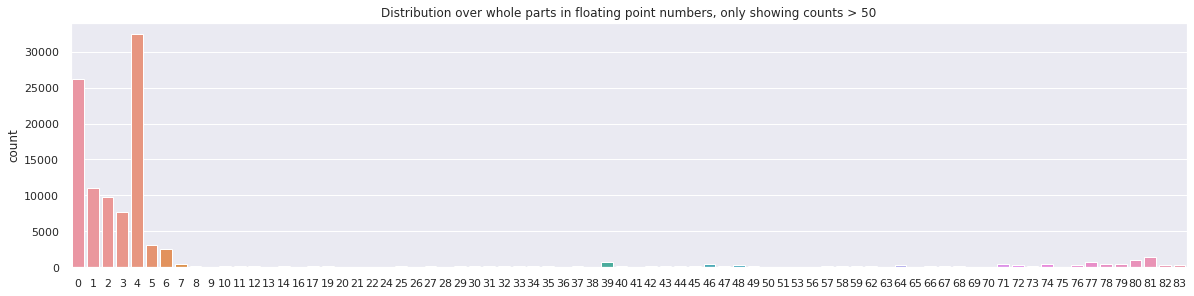

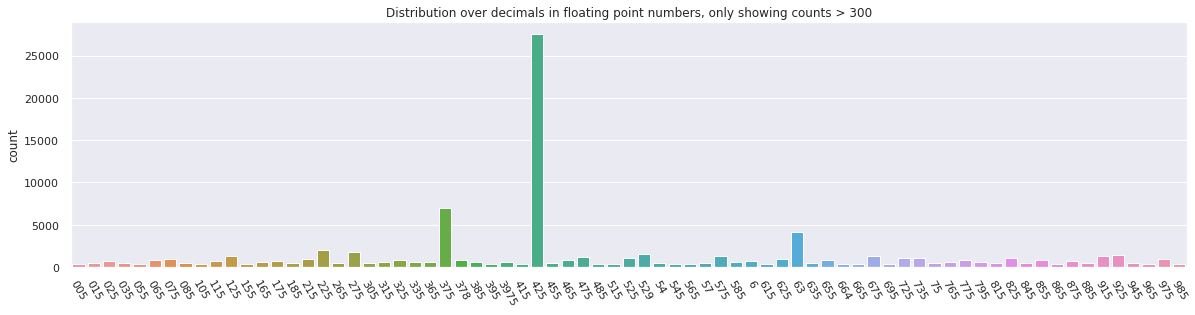

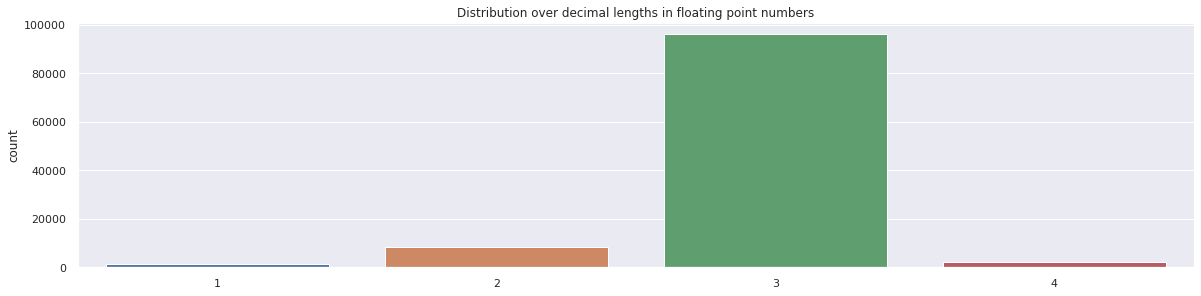

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,4.5)})

# Type '9.345'
results = [item[0] for item in df['fuel_consumption'].str.findall('^(\d+)\.(\d+)$') if len(item) > 0]
wholes = [int(item[0]) for item in results]
decimals = [item[1] for item in results]

from collections import Counter
wholes_counter = Counter(wholes)
wholes_selected = set([k for k, v in wholes_counter.items() if v > 50])
wholes = [w for w in wholes if w in wholes_selected]  # runtime nightmare :)

sns.countplot(x=wholes, order=sorted(set(wholes)))
plt.title("Distribution over whole parts in floating point numbers, only showing counts > 50")
plt.show()

decimals_backup = decimals.copy()
decimals_counter = Counter(decimals)
decimals_selected = set([k for k, v in decimals_counter.items() if v > 300])
decimals = [d for d in decimals if d in decimals_selected]  # runtime nightmare :)

order = list(set(decimals))
order.sort(key=lambda x: float(f'0.{x}'))
sns.countplot(x=decimals, order=order)
plt.title("Distribution over decimals in floating point numbers, only showing counts > 300")
plt.xticks(rotation=-60)
plt.show()

decimal_lengths = [len(str(d)) for d in decimals_backup]
sns.countplot(x=decimal_lengths)
plt.title("Distribution over decimal lengths in floating point numbers")
plt.show()

toggle_cell()

As you can see, the fuel consumptions seem to follow an approximately geometric distribution, do however have a very big spike in the 4.X liter consumption area. You can also see some very high fuel consumptions on the further right end of the range at 70 to 83 liters. This raises the question whether some tracks are *much* longer or steeper than others or whether the number of driven laps differs from race to race and is not included in the dataset. In the extremes, the fuel consumption differs by a factor of approximately 100 (0.8 vs 80 liters). 

As the game included a tuning component, it is also possible that some tuning options had a *very* negative impact on fuel consumption.

Unfortunately, fuel consumption is only given per race, not per race and participant, making an analysis much harder.

In terms of decimal places, most decimal places seem to be three digits long, with a gigantic spike in fuel consumptions of X.425 liters.

As our hypothesis claimed that fuel consumptions with 1 or 2 decimal places were likely to be converted to dates, let's take a look at the kinds of numbers that were left unchanged.

In [8]:
# overview of all whole parts of numbers with exactly one decimal
results = [item[0] for item in df['fuel_consumption'].str.findall('^(\d+)\.(\d)$') if len(item) > 0]
Counter([int(item[0]) for item in results])

Counter({0: 1151})

In [9]:
# overview of all whole parts of all numbers with exactly two decimals
results = [item[0] for item in df['fuel_consumption'].str.findall('^(\d+)\.(\d{2})$') if len(item) > 0]
Counter([int(item[0]) for item in results])

Counter({0: 8403})

In [10]:
# overview of all numbers with a whole part between 1 and 12 and 1 or 2 decimals
results = [item[0] for item in df['fuel_consumption'].str.findall('^([1-9]|1[012])\.(\d{1,2})$') if len(item) > 0]
Counter([item for item in results])

Counter()

In [11]:
# overview of all numbers with a whole part above 12 and 1 or 2 decimals
results = [item[0] for item in df['fuel_consumption'].str.findall('^(1[3-9]|[2-9]\d|\d{3,})\.(\d{1,2})$') if len(item) > 0]
Counter([item for item in results])

Counter()

All unmodified floating-point numbers with 1 or 2 decimal places have the number 0 as their whole part! This means our hypothesis begins to make sense - as you can't interpret the number 0 as any day or month.

In other words, there are no numbers left with a whole part between 1 and 12 and 1 or 2 decimals.

However, it also means there were never any numbers with a whole part above 12 and 1 or 2 decimals - as those could not have been interpreted as month (or day if they are above 31) and should have remained as they are. This is certainly a bit odd, but possible given the low prevalence of fuel consumptions above 12 liters.

For now, let's take a look at the date-shaped entries in the fuel consumption column.

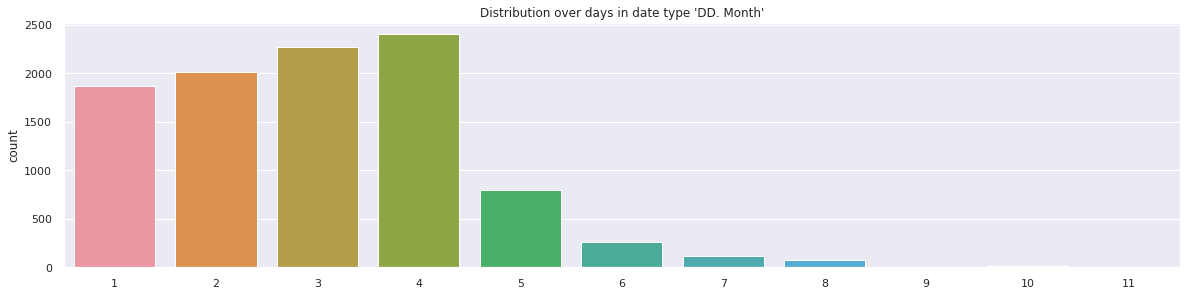

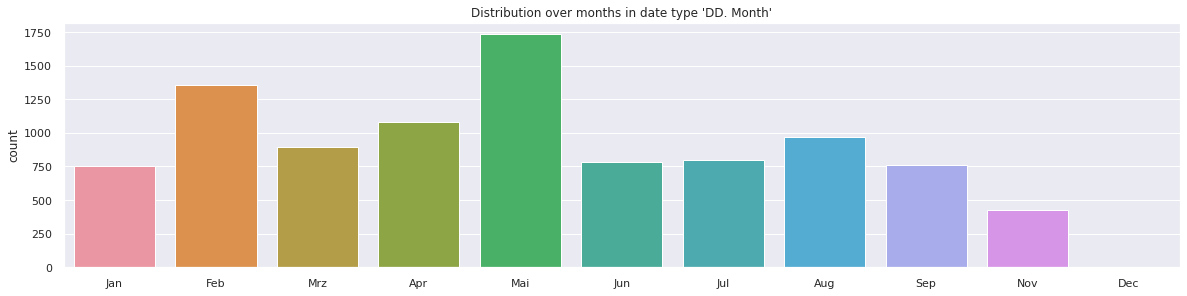

In [12]:
# Type '19. Jan'
results = [item[0] for item in df['fuel_consumption'].str.findall('^(\d+). ([a-zA-Z]{3})') if len(item) > 0]
days = [int(item[0]) for item in results]
months = [item[1] for item in results]

sns.countplot(x=days, order=sorted(set(days)))
plt.title("Distribution over days in date type 'DD. Month'")
plt.show()

sns.countplot(x=months, order=["Jan", "Feb", "Mrz", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Nov", "Dec"])
plt.title("Distribution over months in date type 'DD. Month'")
plt.show()

toggle_cell()

The only month we never observe is October, which makes sense, as we would never see the decimals '.10' (these would just be '.1').

Interestingly, we don't observe any days above 11, despite days up to 31 days being possible.

As our months are the supposed decimal places, we have no way of knowing if January originated from the decimals '.1' or '.01'. When choosing one or the other, we are inevitable loosing some information and are wrong by up to 0.81 ('.9' vs. '.09').

We also observe a tendency towards lower values of the day, not identical but similar to the peak in low whole parts of the numbers.

Let's look at the 'Month YY' type:

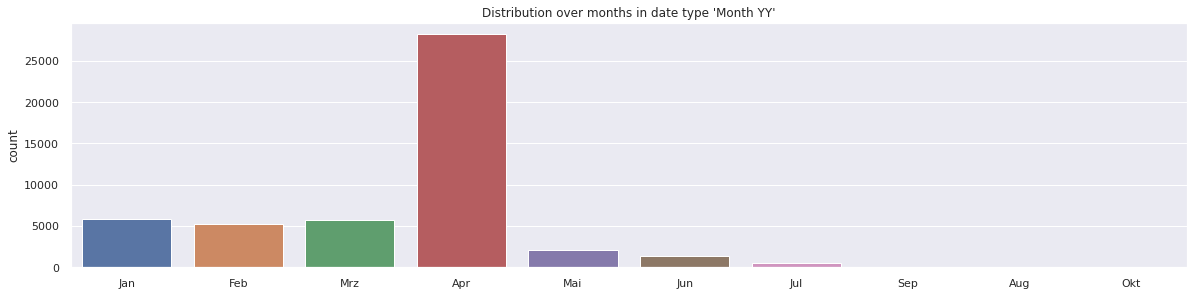

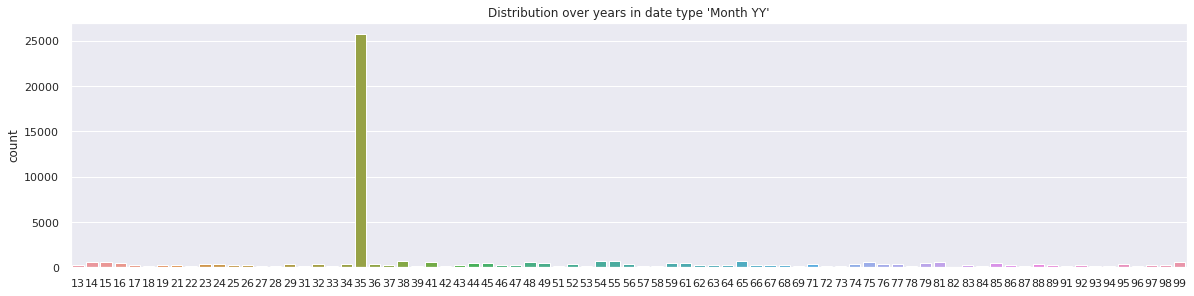

In [13]:
# Type 'Jan 19'
results = [item[0] for item in df['fuel_consumption'].str.findall('^([a-zA-Z]{3}) (\d*)') if len(item) > 0]
months = [item[0] for item in results]
years = [item[1] for item in results]

sns.countplot(x=months)
plt.title("Distribution over months in date type 'Month YY'")
plt.show()

sns.countplot(x=years, order=sorted(set(years)))
plt.title("Distribution over years in date type 'Month YY'")
plt.show()

toggle_cell()

In the months, we again observe a higher prevalence of the values Jan to Apr (1 to 4), just like in the days of the previous dates.

However, the years (assumed decimal places) show no value below 13 (despite being quite evenly distributed otherwise). We also observe a very big spike at the value 35 and a relatively big spike at the value Apr, which we will investigate later. This odd spike is not unique to the date category - we also saw it for numbers 'X.425'.

However, the results we have obtained so far are encouraging and sufficient for our desired application. Our identified generative process for dates looks as follows, where W.D is the original floating point number we want to reconstruct:

![flowchart](flowchart.png)

We will approximate the reversal of this process now, while assuming that 50% of months Jan to Sep of the 'DD. Month' type originate from a single decimal. As long as the decimals are IID (we won't test this), all following statistics such as means should be slightly less biased than when only choosing one of the two.

In [14]:
import datetime
import random
import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

def fuel_to_float(x: str):
    """
    0.234 -> 0.234
    Jan 19 -> 1.19
    01. Feb -> 1.2
    :param x: input string
    :return: cleaned/converted float
    """
    if '. ' in x:
        a, b = x.split('. ')
    elif ' ' in x:
        b, a = x.split(' ')
    else:
        return float(x)
    b = 'Mär' if b == 'Mrz' else b
    b = datetime.datetime.strptime(b, "%b").month
    return float(f"{b}.{random.choice((a.lstrip('0'), a))}")  # this assumes 50% of months Jan to Sep originate from a single decimal

# convert fuel consumption into floats
df['fuel_consumption'] = df['fuel_consumption'].map(fuel_to_float)

Now, lets repeat our floating point number analysis from before.

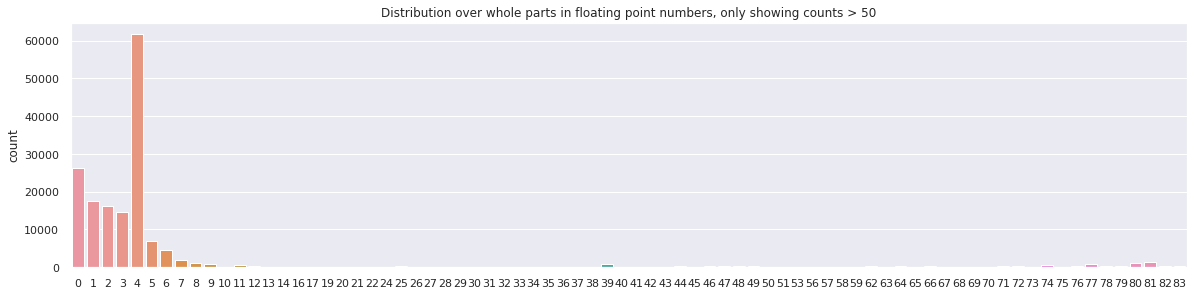

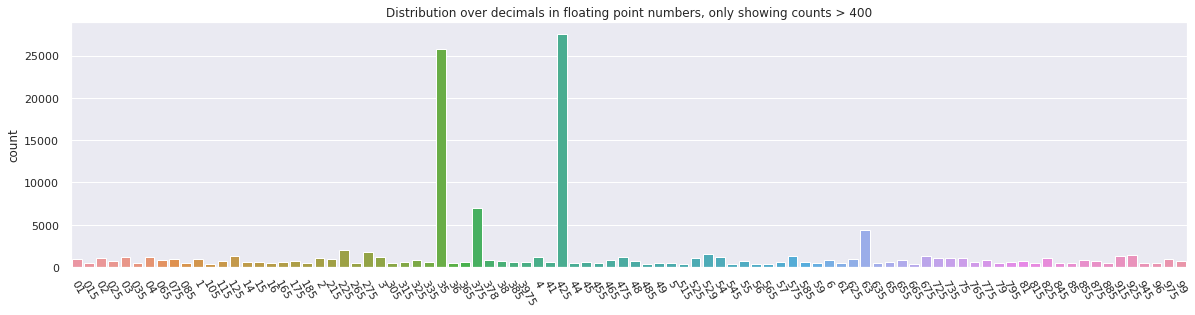

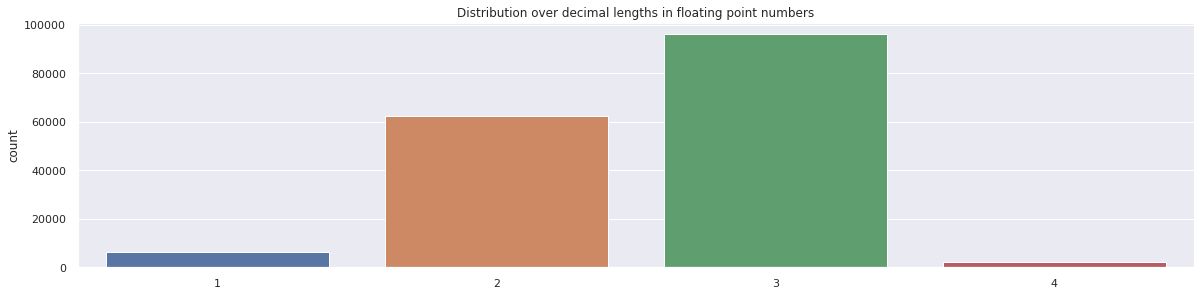

In [15]:
# Type '9.345'
results = [str(item) for item in df['fuel_consumption']]
wholes = [int(item.split('.')[0]) for item in results]
decimals = [item.split('.')[1] for item in results]

from collections import Counter
wholes_counter = Counter(wholes)
wholes_selected = set([k for k, v in wholes_counter.items() if v > 50])
wholes = [w for w in wholes if w in wholes_selected]  # runtime nightmare :)

sns.countplot(x=wholes, order=sorted(set(wholes)))
plt.title("Distribution over whole parts in floating point numbers, only showing counts > 50")
plt.show()

decimals_backup = decimals.copy()
decimals_counter = Counter(decimals)
decimals_selected = set([k for k, v in decimals_counter.items() if v > 400])
decimals = [d for d in decimals if d in decimals_selected]  # runtime nightmare :)

order = list(set(decimals))
order.sort(key=lambda x: float(f'0.{x}'))
sns.countplot(x=decimals, order=order)
plt.title("Distribution over decimals in floating point numbers, only showing counts > 400")
plt.xticks(rotation=-60)
plt.show()

decimal_lengths = [len(str(d)) for d in decimals_backup]
sns.countplot(x=decimal_lengths)
plt.title("Distribution over decimal lengths in floating point numbers")
plt.show()

toggle_cell()

As you can see, the distribution of numbers starts to look more reasonable, however there are still the observed anomalies from before.

Let's look at the distribution of the strange spike at 'X.425' and 'X.35'.

In [16]:
Counter(df['fuel_consumption']).most_common(10)

[(4.425, 26593),
 (4.35, 25523),
 (0.375, 6310),
 (0.63, 4149),
 (2.529, 1506),
 (4.275, 1001),
 (0.378, 845),
 (2.655, 807),
 (3.915, 802),
 (1.065, 774)]

Over 26,000 numbers are exactly '4.425' and over 25,000 numbers are exactly '4.35'! This is around 16% and 15% of our entire dataset and very strange.

An additional 6300 or 3.8% of all numbers are exactly '0.375', followed by 4100 or 2.4% of numbers being '0.63'.

Possible reasons for the high occurrence of these numbers include a software bug or the values being a default of some kind.

If you ignore those four numbers, you get the following plots:

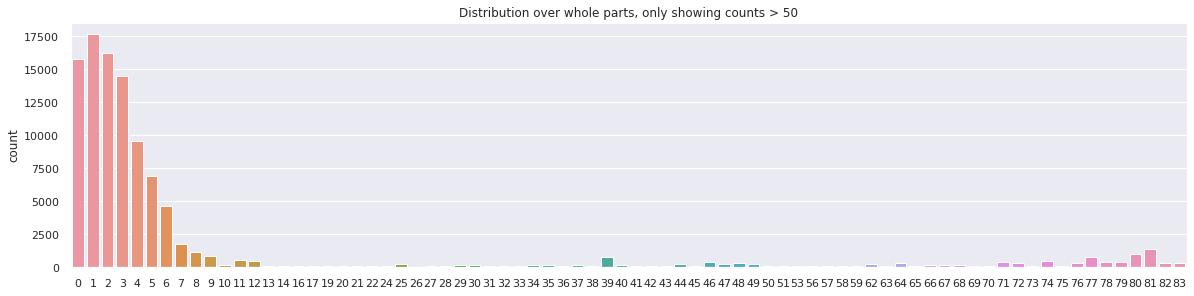

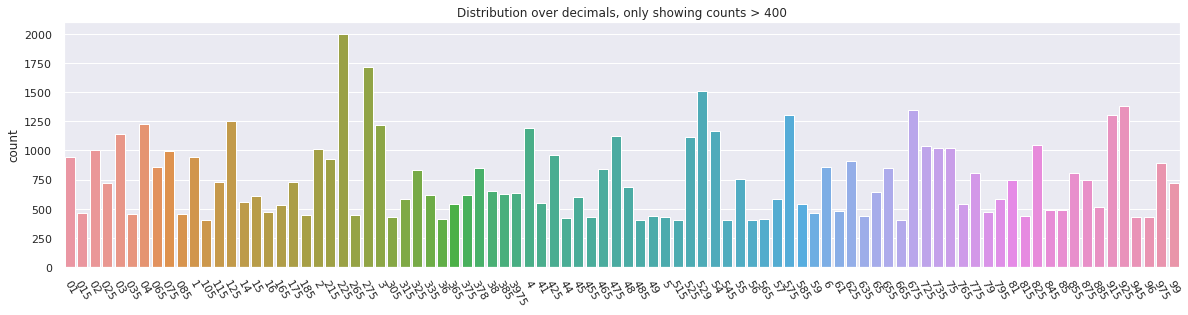

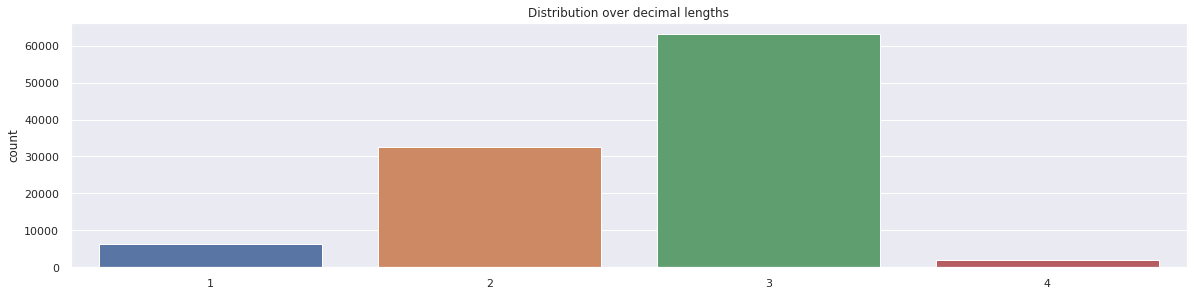

In [17]:
# ignoring numbers 4.425, 4.35, 0.375 and 0.63
results = [str(item) for item in df['fuel_consumption'] if not (np.isnan(item) or item in {4.425, 4.35, 0.375, 0.63})]
wholes = [int(item.split('.')[0]) for item in results]
decimals = [item.split('.')[1] for item in results]

from collections import Counter
wholes_counter = Counter(wholes)
wholes_selected = set([k for k, v in wholes_counter.items() if v > 50])
wholes = [w for w in wholes if w in wholes_selected]  # runtime nightmare :)

sns.countplot(x=wholes, order=sorted(set(wholes)))
plt.title("Distribution over whole parts, only showing counts > 50")
plt.show()

decimals_backup = decimals.copy()
decimals_counter = Counter(decimals)
decimals_selected = set([k for k, v in decimals_counter.items() if v > 400])
decimals = [d for d in decimals if d in decimals_selected]  # runtime nightmare :)

order = list(set(decimals))
order.sort(key=lambda x: float(f'0.{x}'))
sns.countplot(x=decimals, order=order)
plt.title("Distribution over decimals, only showing counts > 400")
plt.xticks(rotation=-60)
plt.show()

decimal_lengths = [len(str(d)) for d in decimals_backup]
sns.countplot(x=decimal_lengths)
plt.title("Distribution over decimal lengths")
plt.show()

toggle_cell()

It is certainly debatable whether the numbers 0.375 and 0.63 have to be removed as well. However, the resulting distribution across decimal places appears to be much more natural after their removal and we have absolutely no qualified insight into why some numbers occur much more often than others.

**This does not mean the four values are wrong - but it indicates that they are not occurring naturally.**

You will read more about these 'overrepresented values' in a later part.

### <span style="color:#4c575f">Step 2: Making Sense of Dates and Times</span>

In the **race_driven** column, many dates are missing. We check if this only applies to stati where it makes sense and compare creation dates with driven dates.

In [18]:
import datetime
pd.set_option('display.max_rows', 100)

# convert race_driven to proper datetime objects
df['race_driven'] = df['race_driven'].map(lambda x: None if x == '0000-00-00 00:00:00' else
                                          datetime.datetime.strptime(x, '%d.%m.%Y %H:%M'))

# do the same for the race_created column (we will need it later)
df['race_created'] = df['race_created'].map(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

# count unique values in status column
print('Stati of races with missing date:')
print(df[df['race_driven'].isnull()]['status'].value_counts())
print('Stati of races with date:')
print(df[df['race_driven'].notnull()]['status'].value_counts())

# check if any race was driven before it was created
print('\nRaces driven before date of creation:')
df[(df['race_driven'] != None) & (df['race_driven'] < df['race_created'])]

Stati of races with missing date:
retired     43224
declined    11392
waiting      2894
Name: status, dtype: int64
Stati of races with date:
finished    109099
Name: status, dtype: int64

Races driven before date of creation:


,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
36004,2012-06-19,2012-06-18 22:50:00,3,13,1,30,0.630,1,finished,rainy,0.05,0.75,0.10,0.10
36009,2012-06-19,2012-06-18 22:55:00,3,13,1,30,0.630,1,finished,thundery,0.10,0.35,0.55,0.00
36032,2012-06-19,2012-06-18 23:54:00,3,1,13,30,0.795,1,finished,sunny,0.80,0.10,0.00,0.10
36033,2012-06-19,2012-06-18 23:59:00,3,1,13,30,0.795,1,finished,thundery,0.50,0.10,0.25,0.15


As the dates are only missing iff the status of the race is retired, declined or waiting, none of the missing dates are an error.

However, four races were driven *before* they were created, even if just by a few minutes. If this is a time zone issue, it indicates that race_created may have been recorded as German date, but race_driven as Coordinated Universal Time (UTC) time stamp, matching the up to 2 hours of possible difference during the month June.

To check if this is a possible explanation, we convert the time from UTC to the Berlin time zone and see if this fixes the issue without creating new anomalies. 

Before doing that, we will however plot one histogram of playing hours during German summer and winter time each. As playing time preferences should not change much over the year, we should see less disagreement between the two histograms after our adjustment.

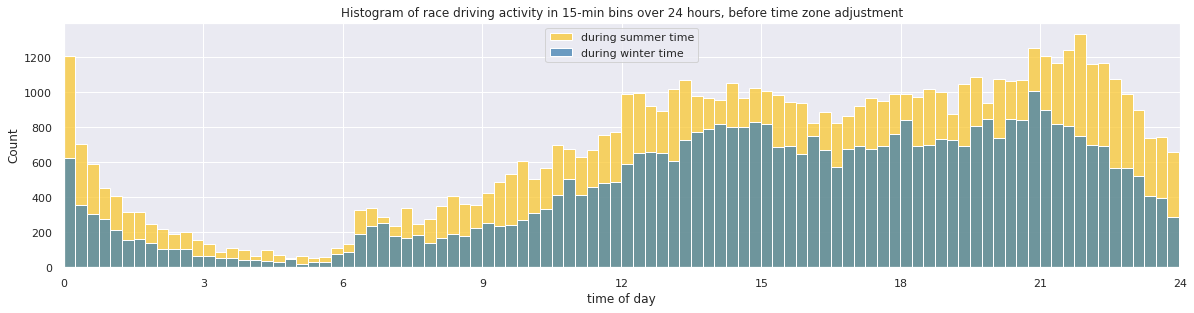

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

is_summer_time = df['race_driven'].map(lambda x: x is not None and 
                                                ((x.month == 3 and x.day > 27) or 
                                                 (x.month > 3 and x.month < 10) or 
                                                 (x.month == 10 and x.day < 27)))
summer_time = df[is_summer_time]['race_driven'].map(lambda x: (x.hour * 60 + x.minute) / 60)

is_winter_time = df['race_driven'].map(lambda x: x is not None and 
                                                ((x.month == 3 and x.day < 27) or 
                                                 (x.month < 3 or x.month > 10) or 
                                                 (x.month == 10 and x.day > 27)))
winter_time = df[is_winter_time]['race_driven'].map(lambda x: (x.hour * 60 + x.minute) / 60)

sns.set(rc={'figure.figsize':(20,4.5)})
sns.set(style="darkgrid") 
fig = sns.histplot(summer_time, bins=24*4, color='#FAC832')
fig = sns.histplot(winter_time, bins=24*4, color='#4181B1')
plt.title('Histogram of race driving activity in 15-min bins over 24 hours, before time zone adjustment')
plt.legend(['during summer time', 'during winter time'])
plt.xlim(0, 24)
plt.xticks([0,3,6,9,12,15,18,21,24])
plt.xlabel('time of day')
plt.show()

toggle_cell()

In [20]:
# convert race_driven times from UTC to Berlin (hours may change)
df['race_driven_converted'] = df['race_driven'].map(lambda x: None if x == None else
                                          x.tz_localize('UTC').tz_convert('Europe/Berlin'))

# claim that race_created times are already in the Berlin time zone (they will remain at 00:00)
df['race_created_converted'] = df['race_created'].map(lambda x: x.tz_localize('Europe/Berlin'))

# check if any race was driven before it was created
print('Races driven before date of creation:')
df[(df['race_driven_converted'] != None) & (df['race_driven_converted'] < df['race_created_converted'])]

Races driven before date of creation:


,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy,race_driven_converted,race_created_converted
id,,,,,,,,,,,,,,,,


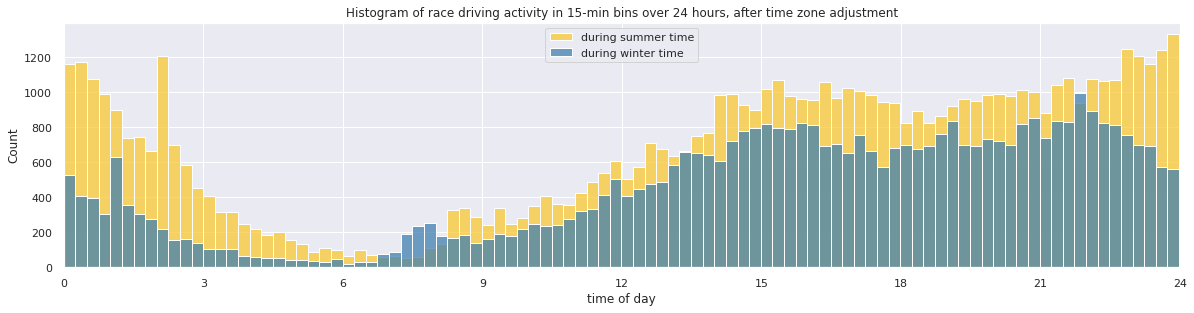

In [21]:
summer_time_conv = df[is_summer_time]['race_driven_converted'].map(lambda x: (x.hour * 60 + x.minute) / 60)

winter_time_conv = df[is_winter_time]['race_driven_converted'].map(lambda x: (x.hour * 60 + x.minute) / 60)

sns.set(rc={'figure.figsize':(20,4.5)})
sns.set(style="darkgrid") 
fig = sns.histplot(summer_time_conv, bins=24*4, color='#FAC832')
fig = sns.histplot(winter_time_conv, bins=24*4, color='#4181B1')
plt.title('Histogram of race driving activity in 15-min bins over 24 hours, after time zone adjustment')
plt.legend(['during summer time', 'during winter time'])
plt.xlim(0, 24)
plt.xticks([0,3,6,9,12,15,18,21,24])
plt.xlabel('time of day')
plt.show()

toggle_cell()

The results we get are not supporting our hypothesis.

On one side, the anomalous races that started before they were created have disappeared.

On the other side, our histograms of racing activity over the day do not lign up as well as they did before. For example, while there was a noticable bump in 'breakfast players' around 6:30 am before our adjustment, these players now seem to play around 7:30am during the winter and around 8:30 am during the summer. We also see two distinct spikes (before: just one) around 1 and 2 am. Both in terms of consistency as well as plausible explainability of the data, the unadjusted times are to be preferred.

We will therefore revert our time zone conversion and instead assume that the date which is slightly off is the creation date - even without knowing by how much or why.

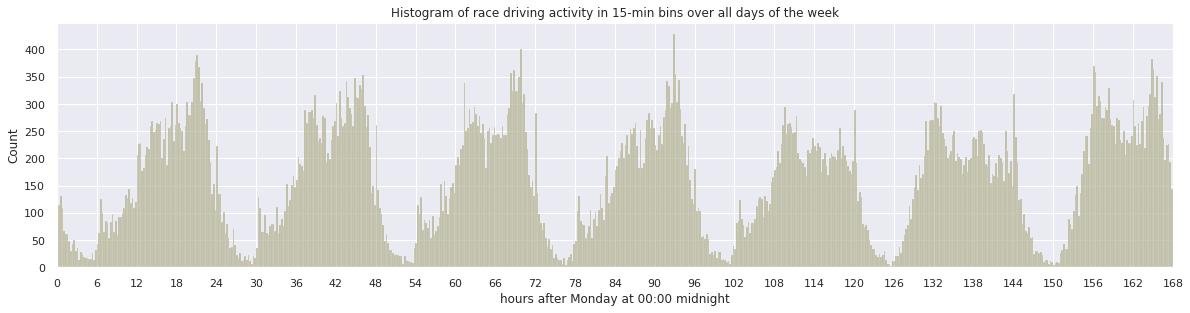

In [22]:
weekday_times = df['race_driven'].map(lambda x: (x.weekday() * 60 * 24 + x.hour * 60 + x.minute) / 60)

sns.set(rc={'figure.figsize':(20,4.5)})
sns.set(style="darkgrid") 
fig = sns.histplot(weekday_times, bins=7*24*4, color='#AEAD8C')
plt.title('Histogram of race driving activity in 15-min bins over all days of the week')
plt.xlim(0, 24*7)
plt.xticks(range(0,168+6,6))
plt.xlabel('hours after Monday at 00:00 midnight')
plt.show()

toggle_cell()

There are no big pattern changes from day to day - other than a lower-than-average activity on Friday and Saturday evening, indicating that users spend that time with something else such as going out or watching a film with their family.

This quick analysis also revealed another interesting anomaly: There seems to be a sudden spike in races shortly after midnight that quickly gets back to normal levels after a few minutes. A possible explanation for this could be a paywall that allows a specific number of free games per player and day and resets every day at midnight.

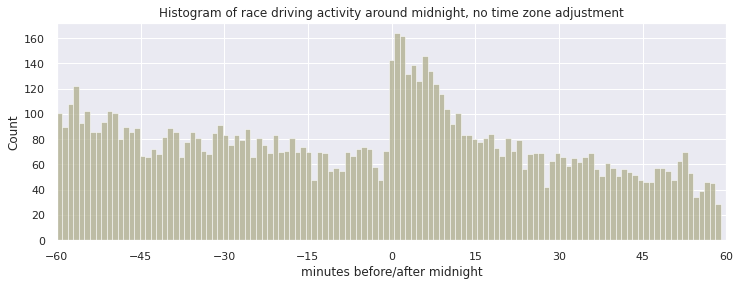

In [23]:
# delete converted datetimes
df.drop('race_driven_converted', inplace=True, axis=1)
df.drop('race_created_converted', inplace=True, axis=1)

# plot midnight anomaly
around_midnight = df['race_driven'].map(lambda x: x is not None and x.hour in {23, 0})

times = df[around_midnight]['race_driven'].map(lambda x: (-60 if x.hour == 23 else 0) + x.minute)

sns.set(rc={'figure.figsize':(12,4)})
sns.set(style="darkgrid") 
fig = sns.histplot(times, bins=120, color='#AEAD8C')
plt.title('Histogram of race driving activity around midnight, no time zone adjustment')
plt.xlim(-60, 60)
plt.xticks(range(-60, 75, 15))
plt.xlabel('minutes before/after midnight')
plt.show()

toggle_cell()

However, as long as this limit is not exactly 1 or above 20, the number of sent challenges, received challenges, and accepted challenges per day and player show no visible break at any threshold but decline rather gracefully and steadily.

As the spike begins directly at the 0 minute mark (and under the assumptions that a) a race takes longer than ~60 seconds and b) no sane person would choose any other time than 00:00 as threshold) we can also infer that the race_driven time marks the beginning, not the end of the driven race.

It seems that another part of the game dynamics must be responsible for the post-midnight-spike in races instead. Possibilities include experience points for each day the game was played or some kind of resource that gets added every day at midnight (e.g. a fixed amount of money or fuel).

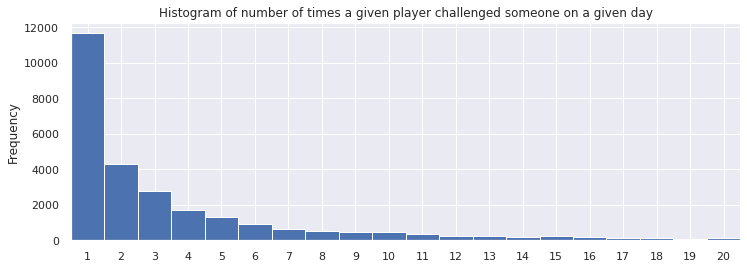

In [24]:
max_num = df.groupby(['challenger', 'race_created']).size().reset_index(name='counts')['counts'].max()
df.groupby(['challenger', 'race_created']).size().reset_index(name='counts')['counts'].plot.hist(bins=np.arange(-0.5, max_num+0.5, 1.0), xlim=(0.5,20.5), xticks=range(0,21,1), title='Histogram of number of times a given player challenged someone on a given day')

toggle_cell()

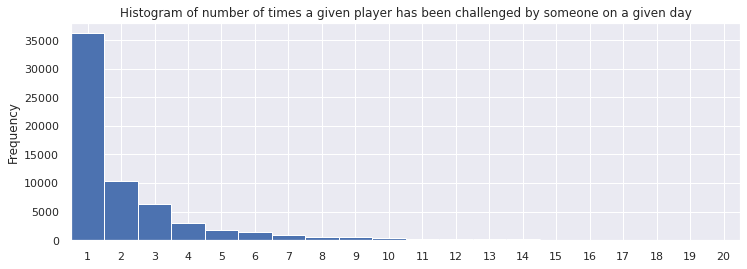

In [25]:
max_num = df.groupby(['opponent', 'race_created']).size().reset_index(name='counts')['counts'].max()
df.groupby(['opponent', 'race_created']).size().reset_index(name='counts')['counts'].plot.hist(bins=np.arange(-0.5, max_num+0.5, 1.0), xlim=(0.5,20.5), xticks=range(0,21,1), title='Histogram of number of times a given player has been challenged by someone on a given day')

toggle_cell()

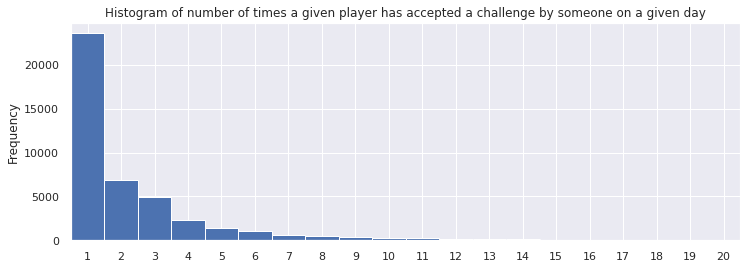

In [26]:
max_num = df.groupby(['opponent', 'race_created']).size().reset_index(name='counts')['counts'].max()
df[df['status']=='finished'].groupby(['opponent', 'race_created']).size().reset_index(name='counts')['counts'].plot.hist(bins=np.arange(-0.5, max_num+0.5, 1.0), xlim=(0.5,20.5), xticks=range(0,21,1), title='Histogram of number of times a given player has accepted a challenge by someone on a given day')

toggle_cell()

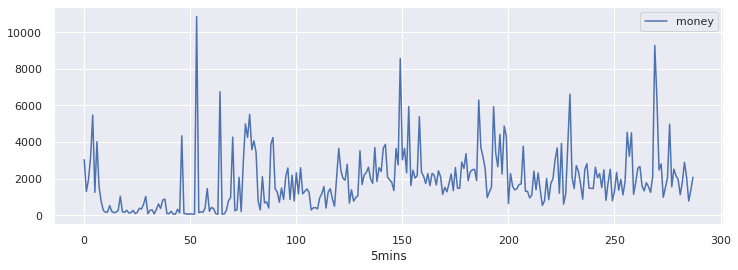

In [27]:
df['5mins'] = df['race_driven'].map(lambda x: (x.hour * 60 + x.minute) // 5)

df.head(10)

df.groupby(by=['5mins']).mean().reset_index().plot(x='5mins', y='money')

# sns.set(rc={'figure.figsize':(20,4.5)})
# sns.set(style="darkgrid") 
# fig = sns.lineplot(x='index', y='money', data=means, bins=24*4, color='#FAC832') 
# plt.title('Histogram of race driving activity in 15-min bins over 24 hours, after time zone adjustment')
# plt.legend(['during summer time', 'during winter time'])
# plt.xlim(0, 24)
# plt.xticks([0,3,6,9,12,15,18,21,24])
# plt.xlabel('time of day')
# plt.show()

# toggle_cell()

df.drop(columns='5mins', inplace=True)

In [28]:
after_midnight = df['race_driven'].map(lambda x: x is not None and x.hour == 0 and x.minute < 15)
df.loc[(df['status']=='finished') & after_midnight].head(100)

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
1,2012-03-06,2012-03-06 00:00:00,12,5,2,30,0.6300,5,finished,rainy,0.10,0.70,0.00,0.20
2,2012-03-06,2012-03-06 00:03:00,12,5,4,30,0.6300,4,finished,sunny,0.70,0.15,0.00,0.15
4,2012-03-06,2012-03-06 00:06:00,12,5,4,30,0.6300,5,finished,sunny,0.25,0.75,0.00,0.00
9,2012-03-06,2012-03-06 00:08:00,3,10,4,30,0.6300,4,finished,sunny,0.45,0.40,0.10,0.05
10,2012-03-06,2012-03-06 00:10:00,12,8,10,30,0.6300,10,finished,sunny,1.00,0.00,0.00,0.00
11,2012-03-06,2012-03-06 00:11:00,12,4,8,30,0.6300,8,finished,rainy,0.75,0.15,0.05,0.05
740,2012-03-06,2012-03-07 00:14:00,12,48,22,30,0.3750,22,finished,sunny,0.65,0.10,0.10,0.15
741,2012-03-06,2012-03-07 00:14:00,12,48,22,30,0.3750,22,finished,thundery,0.00,0.60,0.40,0.00
743,2012-03-06,2012-03-07 00:07:00,12,48,20,30,0.3750,20,finished,thundery,0.60,0.10,0.10,0.20


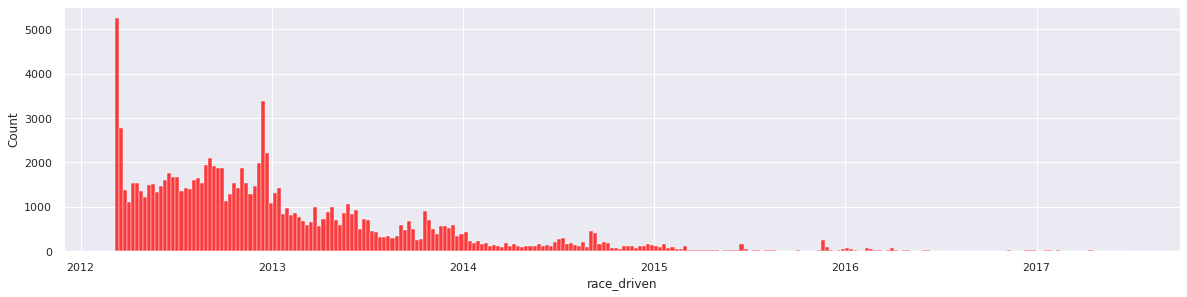

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,4.5)})
before = sns.histplot(data=df['race_driven'], bins=250, color='red')

Now that we have useable dates, let's revisit the odd fuel consumptions from before.

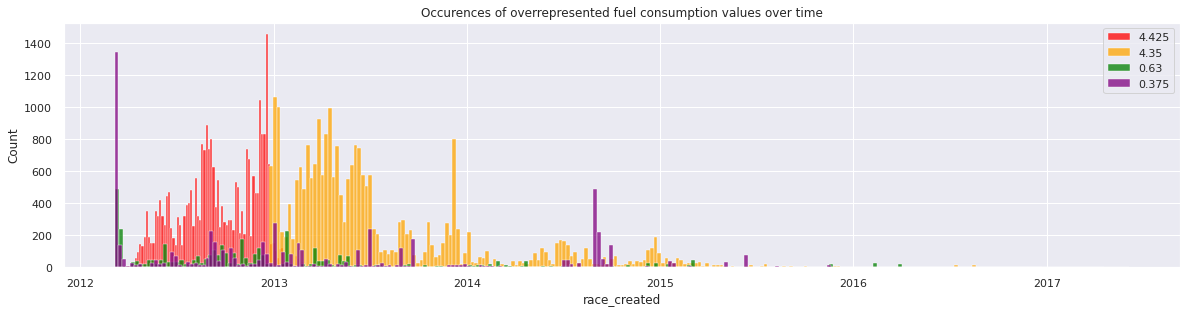

In [30]:
sns.set(rc={'figure.figsize':(20,4.5)})
filtered_a = df.loc[(df['fuel_consumption'] == 4.425)]
filtered_b = df.loc[(df['fuel_consumption'] == 4.35)]
filtered_c = df.loc[(df['fuel_consumption'] == 0.63)]
filtered_d = df.loc[(df['fuel_consumption'] == 0.375)]
for data, color in zip([filtered_a, filtered_b, filtered_c, filtered_d], ['red', 'orange', 'green', 'purple']):
    sns.histplot(data=data['race_created'], bins=250, color=color)
plt.legend(['4.425', '4.35', '0.63', '0.375'])
plt.title('Occurences of overrepresented fuel consumption values over time')
plt.show()

toggle_cell()

As you can see, the extremely common value of 4.425 was replaced by 4.35 around the end of 2012, with both numbers almost exclusively appearing before or after that time point. It therefore seems both numbers have a common cause.

The number 0.375 appears most often on the first few day after the creation of the game (or the beginning of our data, for that matter, set on 2012-03-06), suggesting it may have been a bug.

The number 0.63 appears more or less uniformly across time.

In [31]:
Counter(df.loc[(df['fuel_consumption'] == 0.375)]['race_created']).most_common(10)

[(Timestamp('2012-03-08 00:00:00'), 325),
 (Timestamp('2013-01-02 00:00:00'), 265),
 (Timestamp('2012-03-09 00:00:00'), 257),
 (Timestamp('2014-09-01 00:00:00'), 233),
 (Timestamp('2012-03-11 00:00:00'), 202),
 (Timestamp('2012-03-07 00:00:00'), 173),
 (Timestamp('2014-08-31 00:00:00'), 159),
 (Timestamp('2012-03-10 00:00:00'), 149),
 (Timestamp('2012-03-06 00:00:00'), 142),
 (Timestamp('2014-09-28 00:00:00'), 140)]

Even though track 12 and 3 are the most commonly used tracks, the odd values occur on these two (and track 8) more often than on any other track. As a matter of fact, 4.425 and 4.35 *only* occur on track 3, 8 and 12 and no other track (ignoring one occurrence on track 4, which may have been incidental). Given the big number of occurences and the normally much lower popularity of track 8, this seems like a first hint in the right direction.

In [32]:
Counter(df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['track_id'])

Counter({12: 50286, 3: 1580, 8: 249, 4: 1})

In [33]:
df.loc[(df['fuel_consumption'] == 4.35) & (df['track_id'] == 4)]

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
66218,2012-09-22,2012-09-22 16:03:00,4,4379,2088,30,4.35,4379,finished,thundery,0.6,0.0,0.3,0.1


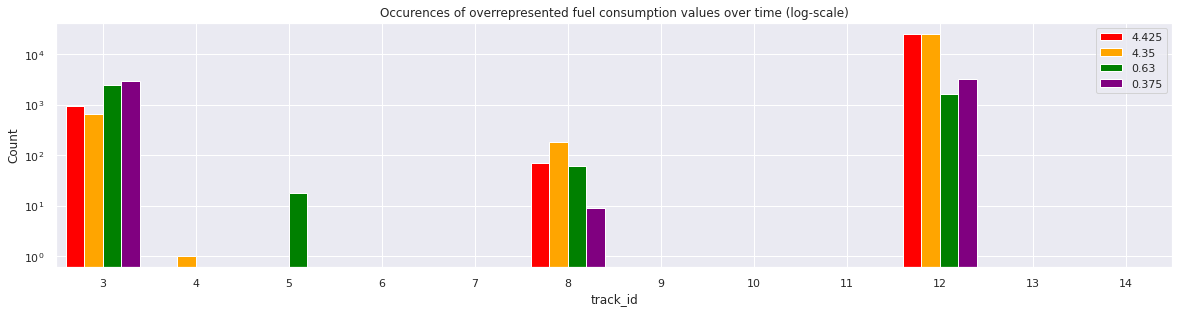

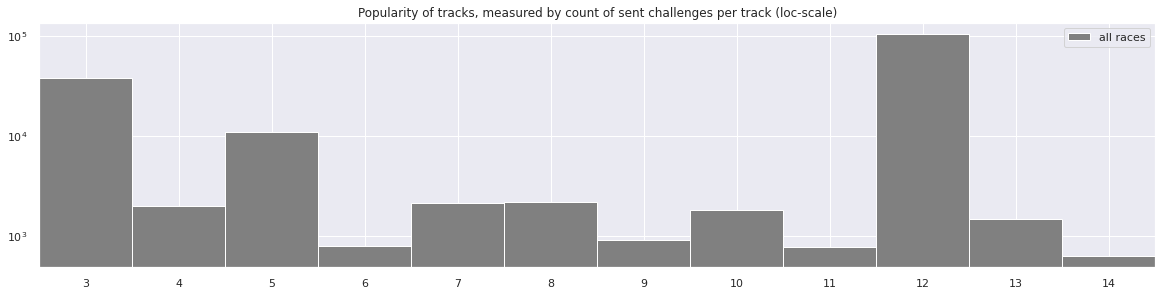

In [34]:
sns.set(rc={'figure.figsize':(20,4.5)})
filtered_a = df.loc[(df['fuel_consumption'] == 4.425)]
filtered_b = df.loc[(df['fuel_consumption'] == 4.35)]
filtered_c = df.loc[(df['fuel_consumption'] == 0.63)]
filtered_d = df.loc[(df['fuel_consumption'] == 0.375)]
# for data, color in zip([filtered_a, filtered_b, filtered_c, filtered_d], ['red', 'orange', 'green', 'purple']):
#     sns.histplot(data=data['track_id'], bins=250, color=color)
plt.hist(x=list(map(lambda x: x['track_id'], [filtered_a, filtered_b, filtered_c, filtered_d])), 
         bins=np.arange(0.5, 13.5, 1.0),
         label=['4.425', '4.35', '0.63', '0.375'],
         color=['red', 'orange', 'green', 'purple'])
plt.legend()
plt.title('Occurences of overrepresented fuel consumption values over time (log-scale)')
plt.xticks(range(3,15))
plt.xlim(2.5, 14.5)
plt.yscale('log')
plt.xlabel('track_id')
plt.ylabel('Count')
plt.show()

sns.set(rc={'figure.figsize':(20,4.5)})
plt.hist(x=df['track_id'], 
         bins=np.arange(0.5, 15.5, 1.0),
         label='all races',
         color='grey')
plt.legend()
plt.title('Popularity of tracks, measured by count of sent challenges per track (loc-scale)')
plt.xticks(range(3,15))
plt.xlim(2.5, 14.5)
plt.yscale('log')
plt.show()

toggle_cell()

There is no apparent difference between the stati of races with 'normal' and overrepresented fuel consumptions.

In [35]:
stati = ['finished', 'retired', 'declined', 'waiting']
print('Distribution of stati excluding overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] != 4.425) & (df['fuel_consumption'] != 4.35)]['status']
c = Counter(filtered)
for i in stati:
    print(f"  {i}: {(c[i] / len(filtered)):.2%}")
print('\nDistribution of stati of overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['status']
c = Counter(filtered)
for i in stati:
    print(f"  {i}: {(c[i] / len(filtered)):.2%}")
    
toggle_cell()

Distribution of stati excluding overrepresented fuel consumptions:
  finished: 63.92%
  retired: 24.79%
  declined: 8.77%
  waiting: 2.52%

Distribution of stati of overrepresented fuel consumptions:
  finished: 68.91%
  retired: 28.47%
  declined: 2.60%
  waiting: 0.02%


The same applies to the observed weather:

In [36]:
stati = [np.nan, 'sunny', 'rainy', 'snowy', 'thundery']
print('Distribution of weather excluding overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] != 4.425) & (df['fuel_consumption'] != 4.35)]['weather']
c = Counter(filtered)
for i in stati:
    print(f"  {i}: {(c[i] / len(filtered)):.2%}")
print('\nDistribution of weather of overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['weather']
c = Counter(filtered)
for i in stati:
    print(f"  {i}: {(c[i] / len(filtered)):.2%}")
    
toggle_cell()

Distribution of weather excluding overrepresented fuel consumptions:
  nan: 36.08%
  sunny: 31.77%
  rainy: 16.06%
  snowy: 8.04%
  thundery: 8.06%

Distribution of weather of overrepresented fuel consumptions:
  nan: 31.09%
  sunny: 35.18%
  rainy: 17.09%
  snowy: 8.24%
  thundery: 8.39%


Interestingly, the odd fuel consumptions are much more likely to have player 48 as challenger and player 0 as opponent:

In [37]:
print('Distribution of top 5 opponents excluding overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] != 4.425) & (df['fuel_consumption'] != 4.35)]['opponent']
c = Counter(filtered)
for i in c.most_common(5):
    print(f"  {i[0]}: {(i[1] / len(filtered)):.2%}")
    
print('\nDistribution of top 5 opponents of overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['opponent']
c = Counter(filtered)
for i in c.most_common(5):
    print(f"  {i[0]}: {(i[1] / len(filtered)):.2%}")

print('\nDistribution of top 5 challengers excluding overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] != 4.425) & (df['fuel_consumption'] != 4.35)]['challenger']
c = Counter(filtered)
for i in c.most_common(5):
    print(f"  {i[0]}: {(i[1] / len(filtered)):.2%}")
    
print('\nDistribution of top 5 challengers of overrepresented fuel consumptions:')
filtered = df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['challenger']
c = Counter(filtered)
for i in c.most_common(5):
    print(f"  {i[0]}: {(i[1] / len(filtered)):.2%}")
    
toggle_cell()

Distribution of top 5 opponents excluding overrepresented fuel consumptions:
  0: 3.37%
  48: 1.01%
  2866: 0.59%
  32: 0.51%
  3001: 0.46%

Distribution of top 5 opponents of overrepresented fuel consumptions:
  0: 21.74%
  48: 4.95%
  2866: 3.71%
  32: 2.62%
  55: 2.10%

Distribution of top 5 challengers excluding overrepresented fuel consumptions:
  32: 2.59%
  46: 1.51%
  5: 1.07%
  3: 0.96%
  2866: 0.92%

Distribution of top 5 challengers of overrepresented fuel consumptions:
  48: 30.87%
  2866: 7.38%
  46: 4.76%
  55: 4.11%
  148: 3.80%


Where (almost) all races with opponent 0 have the status 'retired':

In [38]:
Counter(df.loc[(df['opponent'] == 0)]['status']).most_common(10)

[('retired', 15189), ('waiting', 1)]

Opponent 0 existing in the first place is very strange - you shouldn't be able to challenge 'nobody'. A possible explanation is that these kinds of challenges were sent to non-players of the game (e.g. via an email invitation to sign up to the game) and hence to people without a player ID.

Equally strange is that fuel was consumed in a retired race at all - the fuel consumption here should be 0. A possible explanation would be that the last observed fuel consumption is entered here - however this behavior does not seem interesting enough for further investigation.

More interestingly, only 155 challengers are responsible for all odd fuel consumptions, making up around 30% of the data.
Only *one* of them has *only* overrepresented fuel consumptions, all other 154 players have both types of fuel consumptions.

In [39]:
print("Unique challengers among 'normal' fuel consumptions:")
normies = Counter(df.loc[(df['fuel_consumption'] != 4.425) & (df['fuel_consumption'] != 4.35)]['challenger']).keys()
print(len(normies))

print("\nUnique challengers among overrepresented fuel consumptions:")
oddies = Counter(df.loc[(df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)]['challenger']).keys()
print(len(oddies))

print("\nOnly player with EXCLUSIVELY overrepresented fuel consumption values:")
print(set(oddies).difference(set(normies)))

toggle_cell()

Unique challengers among 'normal' fuel consumptions:
4093

Unique challengers among overrepresented fuel consumptions:
155

Only player with EXCLUSIVELY overrepresented fuel consumption values:
{4379}


 Coincidentally this player is also the only player with odd fuel consumptions that has ever driven on track 4 (a few cell above we established that other than for one entry, all odd fuel consumptions occur only on track 3, 8 and 12).

In [40]:
df.loc[(df['challenger'] == 4379)]

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
66218,2012-09-22,2012-09-22 16:03:00,4,4379,2088,30,4.35,4379,finished,thundery,0.6,0.0,0.3,0.1


When looking at the top 5 challengers (48, 2866, 46, 55, 148) producing the overrepresented values over time, we see that for every player only normal values were produced in the beginning. After some time, the overrepresented fuel consumptions appear and dominate the timeline - only sometimes, normal values pop up again.

This strongly indicates that those players have purchased an upgrade (or: a separate vehicle) that results in a fixed fuel consumption - the fixed consumption of which was adjusted from 4.625 to 4.35 at the end of 2012. From time to time those players however fall back to using other vehicles too, be it because of nostalgic factors or because those other vehicles have other advantages unknown to us. It is also possible that instead of a fixed fuel consumption, the upgrade resulted in an upper limit of fuel consumption that was not always reached. This variant is however not supported by later data.

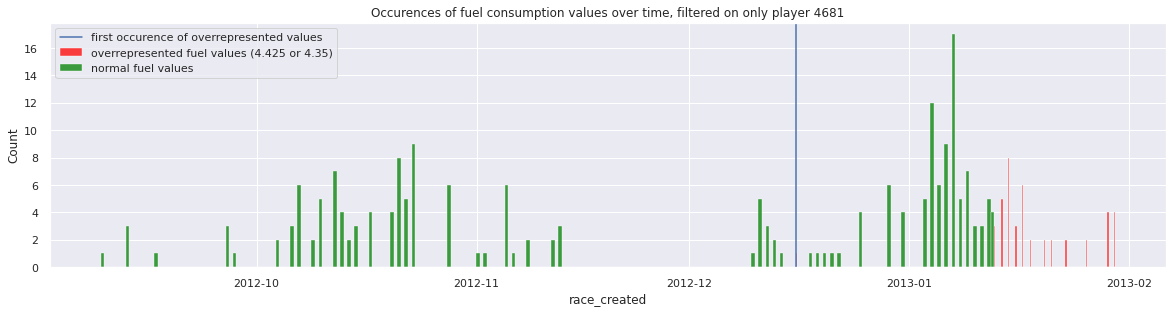

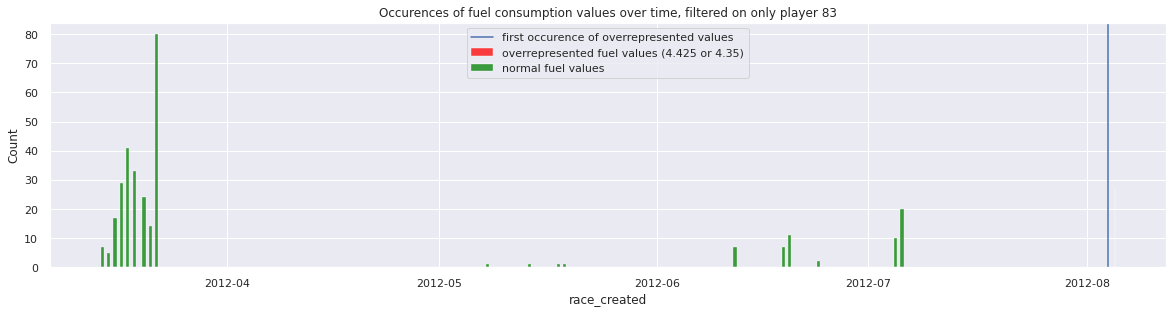

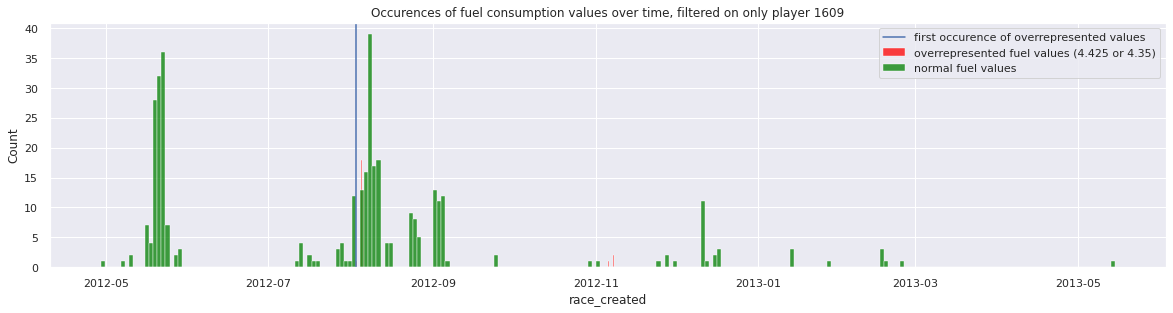

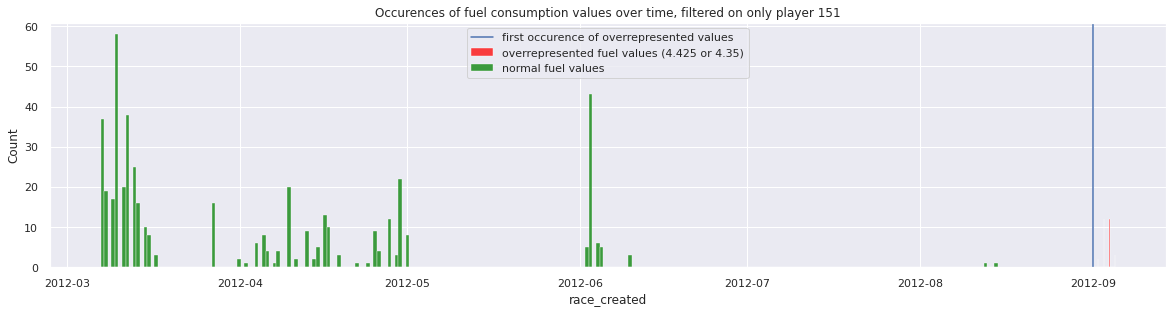

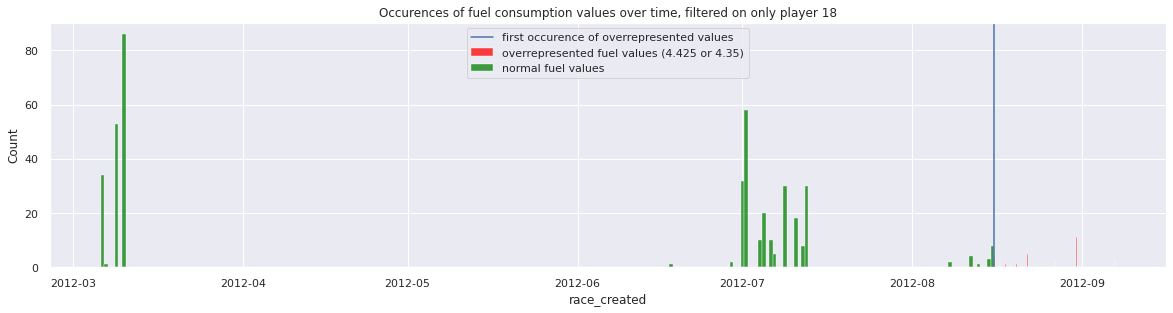

In [41]:
fuel_values = (4.425, 4.35)

filtered = df.loc[(df['fuel_consumption'] == fuel_values[0]) | (df['fuel_consumption'] == fuel_values[1])]['challenger']
c = Counter(filtered)
mc = [x[0] for x in c.most_common(5)]

def plot_behavior(player):
    sns.set(rc={'figure.figsize':(20,4.5)})
    filtered_a = df.loc[(df['fuel_consumption'] != fuel_values[0]) & (df['fuel_consumption'] != fuel_values[1]) & (df['challenger'] == player)]
    filtered_b = df.loc[((df['fuel_consumption'] == fuel_values[0]) | (df['fuel_consumption'] == fuel_values[1])) & (df['challenger'] == player)]
    min_date = df.loc[((df['fuel_consumption'] == fuel_values[0]) | (df['fuel_consumption'] == fuel_values[1])) & (df['challenger'] == player)]['race_created'].min()
    for data, color in zip([filtered_b, filtered_a], ['red', 'green']):
        sns.histplot(data=data['race_created'], bins=250, color=color)
    plt.axvline(min_date, 0,8)
    plt.legend(['first occurence of overrepresented values', 'overrepresented fuel values (4.425 or 4.35)', 'normal fuel values'])
    plt.title(f'Occurences of fuel consumption values over time, filtered on only player {player}')
    plt.show()
    
for p in mc:
    plot_behavior(p)

toggle_cell()

Our hypothesis of some kind of upgrade or new vehicle is further supported by the average daily fuel consumption before and after the first occurence of the overrepresented values.

The typical pattern includes a very high fuel consumption right before the first occurence of the overrepresented fuel value - likely the motivation for the purchase.

It is possible that those 155 players payed real money for that upgrade in a microtransaction.

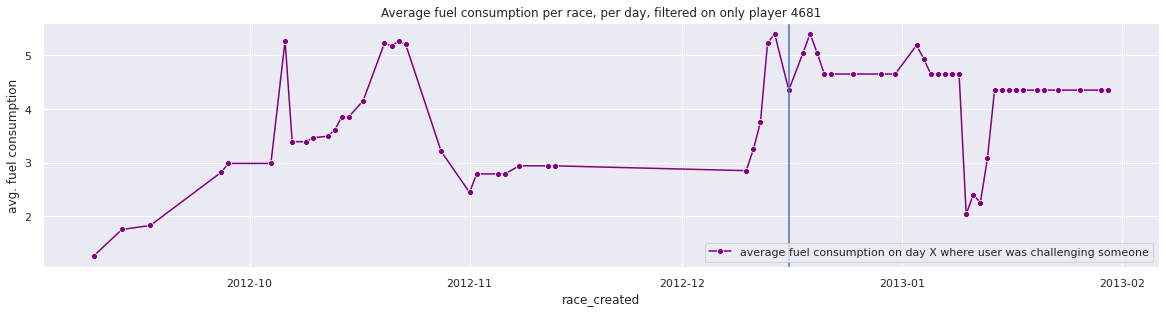

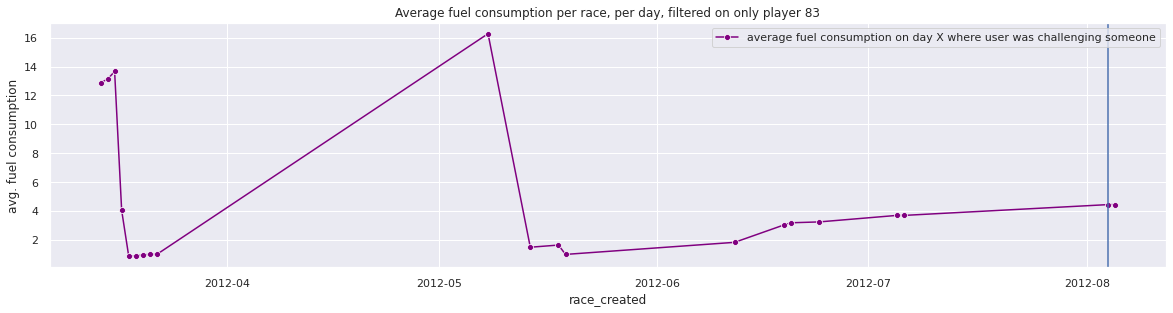

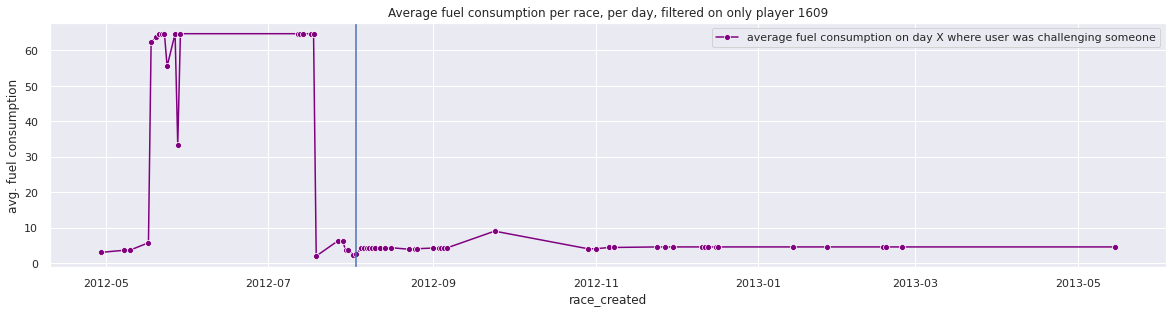

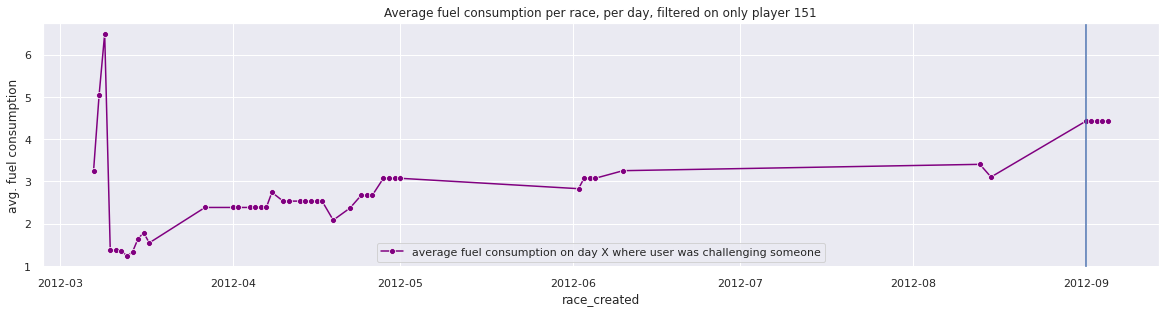

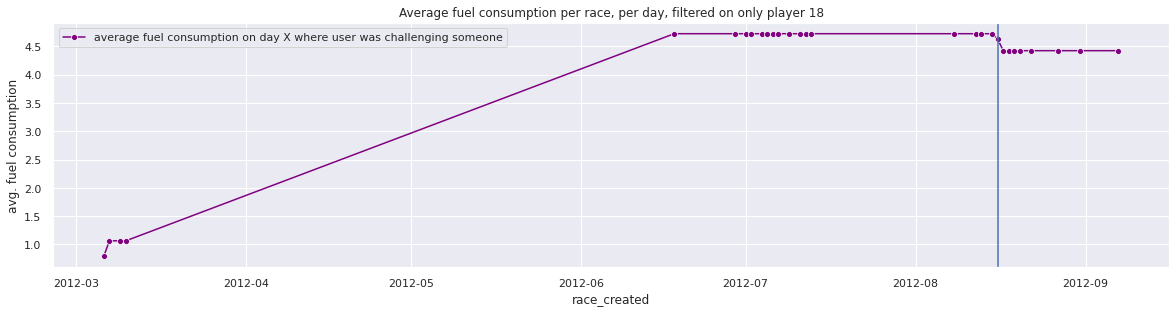

In [42]:
def plot_avg_fuel(player):
    sns.set(rc={'figure.figsize':(20,4.5)})
    filtered = df.loc[(df['challenger'] == player)]
    min_date = df.loc[((df['fuel_consumption'] == 4.425) | (df['fuel_consumption'] == 4.35)) & (df['challenger'] == player)]['race_created'].min()
    gb = filtered.groupby(by='race_created').mean()
    sns.lineplot(x=gb.index.values, y=gb['fuel_consumption'], color=color, markers=True, style=True)
    # sns.histplot(data=gb, bins=250, color=color)
    plt.axvline(min_date, 0,8)
    plt.legend(['average fuel consumption on day X where user was challenging someone'])
    plt.title(f'Average fuel consumption per race, per day, filtered on only player {player}')
    plt.xlabel('race_created')
    plt.ylabel('avg. fuel consumption')
    plt.show()
    
for p in mc:
    plot_avg_fuel(p)

toggle_cell()

In [43]:
# df['fuel_consumption'].replace({4.425: None, 4.35: None, 0.375: None, 0.63: None}, inplace=True)

![crystal ball](https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/120/google/313/crystal-ball_1f52e.png)

## <span style="color:#d82a45">**Chapter 2:**</span> <span style="color:#4c575f">Modelling the Future</span>
In Chapter 1, we looked at, and tried to clean and understand all available data. Now comes the fun part: learning from the data and trying to make predictions about the future.

Naturally, players of any game have varying skill levels. Which player has which skill level can be established over time by observing who wins which game against whom.

A simple such method for calculating relative skill levels is the ELO ranking system, named after Arpad Elo, its inventor. ELO was conceived in 1959 and is still commonly used for simple zero-sum games such as chess. However, ELO has many drawbacks, the biggest ones being that it can only model games with exactly two players and allows for almost no customization. In 2006, Ralf Herbrich, Tom Minka and Thore Graepel from Microsoft Research developed TrueSkill™, a much more flexible ranking system than ELO, which has since been applied to almost all online games in existence. It is highly likely that TrueSkill™ was used for our racing game as well.

As TrueSkill™ can be modified in multiple ways, it is unlikely that we will have exactly the same configuration as the one used in the original game, and hence our own scores and rankings will slightly differ from the ones produced by the game. However, they should give a somewhat reliable impression of how good and bad players are distributed.

We will use the publicly available Python implementation of TrueSkill™. Learn more here: https://trueskill.org/

We will use default values for the configuration of TrueSkill™. As there are no races resulting in a draw in our dataset, we will set the draw probability to 0%.

TrueSkill™ will return the values mu, the mean skill and sigma, the square root of the variance of the skill of each player. A leaderboard can be calculated by ranking players by their conservative skill estimate mu - sigma.

In [47]:
from collections import defaultdict
import trueskill
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

trueskill.setup(mu=25, sigma=8.333, beta=4.166, tau=0.08333, draw_probability=0.0)

finished_races = df.loc[(df['status'] == 'finished')]

ratings = defaultdict(trueskill.Rating)

for index, row in finished_races.iterrows():
    c = row['challenger']
    o = row['opponent']
    w = row['winner']
    if len({c, o, w}) != len({c, o}) != 2:
        raise ValueError(f'Illegal combination of challenger {c}, opponent {o}, and winner {w}.')
    winner, loser = (c, o) if c == w else (o, c)
    rating_pair = (ratings[winner], ratings[loser])
    ratings[winner], ratings[loser] = trueskill.rate_1vs1(*rating_pair)

leaderboard = sorted(ratings.items(), key=lambda item: trueskill.expose(item[1]), reverse=True)

In [50]:
print(len(leaderboard))

5749


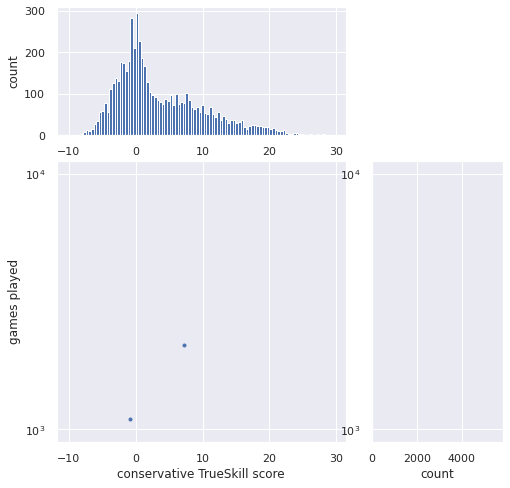

0.05040921395396566


In [49]:
counts_c = Counter(finished_races['challenger'].value_counts())
counts_o = Counter(finished_races['opponent'].value_counts())
counts = counts_c + counts_o

X, Y = [], []
for idx, skill in leaderboard:
    X.append(trueskill.expose(skill))
    Y.append(counts[idx])


fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)

ax_main.scatter(X, Y, marker='.')
ax_main.set(xlabel="conservative TrueSkill score", ylabel="games played")
plt.yscale('log')

ax_xDist.hist(X, bins=100, align='mid')
ax_xDist.set(ylabel='count')

ax_yDist.hist(Y, bins=10000, orientation='horizontal', align='mid')
ax_yDist.set(xlabel='count')

plt.show()

corr, _ = pearsonr(X, Y)
print(corr)

In [ ]:
# winning prob
from trueskill import Rating
from trueskill.mathematics import cdf

def Pwin(rA=Rating(), rB=Rating()):
    deltaMu = rA.mu - rB.mu
    rsss = sqrt(rA.sigma**2 + rB.sigma**2)
    return cdf(deltaMu/rsss)